In [1]:
import pandas as pd
import numpy as np
import os

In [2]:
pd.set_option('display.max_columns', None)

# Read datasets from the interim directory
X_train = pd.read_pickle("../../data/interim/X_train.pkl")
X_val = pd.read_pickle("../../data/interim/X_val.pkl")
X_test = pd.read_pickle("../../data/interim/X_test.pkl")
y_train = pd.read_pickle("../../data/interim/y_train.pkl")
y_val = pd.read_pickle("../../data/interim/y_val.pkl")
y_test = pd.read_pickle("../../data/interim/y_test.pkl")

In [4]:
X_train.head()

,acc_x,acc_y,acc_z,gyro_x,gyro_y,gyro_z
96879,-0.458843,-0.004343,-0.272226,0.032586,-0.057479,0.017799
96880,-0.881271,0.789259,-0.322166,0.031217,-0.012802,-0.002940
96881,-0.750800,0.547177,-0.330515,0.042022,0.011359,-0.011404
96882,-0.640295,0.394234,-0.315634,0.030857,0.012073,-0.015476
96883,-0.686538,0.550332,-0.359439,0.009593,0.003928,-0.010498


## Segment Data into Windows

Define a function to create windows of your desired size (e.g., 2.5-second windows):

Window size: 50 samples (1 sec at 20 Hz)

Overlap: 50% (step = 50 samples)


In [25]:
sensor_cols = ['acc_x', 'acc_y', 'acc_z', 'gyro_x', 'gyro_y', 'gyro_z']

def create_windows(X, y, window_size=50, step_size=25):
    X_windows, y_windows = [], []
    
    for start in range(0, len(X) - window_size + 1, step_size):
        end = start + window_size
        window_data = X[start:end]
        window_labels = y[start:end]

        # Majority voting for label assignment
        unique, counts = np.unique(window_labels, return_counts=True)
        label = unique[np.argmax(counts)]

        X_windows.append(window_data)
        y_windows.append(label)

    return np.array(X_windows), np.array(y_windows)

This generates windows of data (X) with corresponding labels (y).

In [ ]:
X_train_windows, y_train_windows = create_windows(X_train, y_train)
X_val_windows, y_val_windows = create_windows(X_val, y_val)
X_test_windows, y_test_windows = create_windows(X_test, y_test)

In [ ]:
X_train_windows

array([[[-4.58842772e-01, -4.34270089e-03, -2.72225870e-01,
          3.25857811e-02, -5.74788390e-02,  1.77991929e-02],
        [-8.81270879e-01,  7.89258603e-01, -3.22165890e-01,
          3.12170927e-02, -1.28021585e-02, -2.94008199e-03],
        [-7.50800394e-01,  5.47177146e-01, -3.30514817e-01,
          4.20216105e-02,  1.13589196e-02, -1.14037572e-02],
        ...,
        [-7.18744645e-01,  5.25246497e-01, -2.47927396e-01,
          2.60944491e-02, -1.06792088e-01,  6.72585823e-03],
        [-6.90880621e-01,  5.41102919e-01, -2.44688472e-01,
          2.14500557e-02, -9.42392864e-02,  1.09713888e-02],
        [-6.61968212e-01,  5.38431986e-01, -2.71893843e-01,
          1.57813459e-02, -8.33140576e-02,  3.59755313e-03]],

       [[-6.84860115e-01,  5.21784583e-01, -2.22337900e-01,
         -6.17227406e-02,  2.38035059e-01,  4.46414423e-02],
        [-6.97513028e-01,  5.24532542e-01, -2.26559253e-01,
         -6.38338113e-02,  2.32240385e-01,  4.69323234e-02],
        [-6.88705

In [ ]:
y_train_windows

array(['STD', 'STD', 'STD', ..., 'CSO', 'CSO', 'STD'],
      shape=(55629,), dtype='<U3')

## Encode Labels

Convert string labels to numeric (for CNN training)

In [ ]:
from sklearn.preprocessing import LabelEncoder

# Initialize the LabelEncoder
le = LabelEncoder()

# Fit and transform on the windowed training labels
y_train_windows_encoded = le.fit_transform(y_train_windows)

# Transform the validation and test windowed labels based on the same encoding
y_val_windows_encoded = le.transform(y_val_windows)
y_test_windows_encoded = le.transform(y_test_windows)

# CNN

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, GlobalAveragePooling1D, Dense, Dropout
from tensorflow.keras.optimizers import Adam

# Define the input shape (e.g., 25 time steps, 6 channels)
input_shape = (X_train_windows.shape[1], X_train_windows.shape[2])
num_classes = len(set(y_train_windows_encoded))  # Should be 15 based on your labels

model = Sequential([
    # First convolutional block
    Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=input_shape),
    # Second convolutional block
    Conv1D(filters=128, kernel_size=3, activation='relu'),
    # Apply max pooling to reduce sequence length and capture dominant features
    MaxPooling1D(pool_size=2),
    # Third convolutional block
    Conv1D(filters=128, kernel_size=3, activation='relu'),
    # Global average pooling to flatten the tensor for the dense layer
    GlobalAveragePooling1D(),
    # Fully connected (dense) layer with dropout
    Dense(64, activation='relu'),
    Dropout(0.5),
    # Output layer: softmax activation for multi-class classification
    Dense(num_classes, activation='softmax')
])

# Compile the model with a common optimizer and loss function for classification
model.compile(optimizer=Adam(learning_rate=0.001),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

# Display the model architecture
model.summary()


c:\Users\sovan\Desktop\Fall Detection\fresh-ilab-fall-detection\.venv\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d (Conv1D)                 │ (None, 98, 64)         │         1,216 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_1 (Conv1D)               │ (None, 96, 128)        │        24,704 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d (MaxPooling1D)    │ (None, 48, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_2 (Conv1D)               │ (None, 46, 128)        │        49,280 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling1d        │ (None, 128)            │             0 │
│ (GlobalAveragePooling1D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 16)             │         1,040 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 84,496 (330.06 KB)

 Trainable params: 84,496 (330.06 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# Train the model
history = model.fit(X_train_windows, y_train_windows_encoded,
                    validation_data=(X_val_windows, y_val_windows_encoded),
                    epochs=25, batch_size=32)

Epoch 1/25
1739/1739 ━━━━━━━━━━━━━━━━━━━━ 19s 10ms/step - accuracy: 0.6897 - loss: 1.0439 - val_accuracy: 0.7810 - val_loss: 0.6661
Epoch 2/25
1739/1739 ━━━━━━━━━━━━━━━━━━━━ 17s 10ms/step - accuracy: 0.8498 - loss: 0.4529 - val_accuracy: 0.8269 - val_loss: 0.5131
Epoch 3/25
1739/1739 ━━━━━━━━━━━━━━━━━━━━ 17s 10ms/step - accuracy: 0.8716 - loss: 0.3808 - val_accuracy: 0.8200 - val_loss: 0.5298
Epoch 4/25
1739/1739 ━━━━━━━━━━━━━━━━━━━━ 17s 10ms/step - accuracy: 0.8859 - loss: 0.3300 - val_accuracy: 0.7432 - val_loss: 0.6958
Epoch 5/25
1739/1739 ━━━━━━━━━━━━━━━━━━━━ 17s 10ms/step - accuracy: 0.8943 - loss: 0.3066 - val_accuracy: 0.7869 - val_loss: 0.6054
Epoch 6/25
1739/1739 ━━━━━━━━━━━━━━━━━━━━ 17s 10ms/step - accuracy: 0.9017 - loss: 0.2856 - val_accuracy: 0.7906 - val_loss: 0.5627
Epoch 7/25
1739/1739 ━━━━━━━━━━━━━━━━━━━━ 17s 10ms/step - accuracy: 0.9055 - loss: 0.2652 - val_accuracy: 0.8041 - val_loss: 0.6504
Epoch 8/25
1739/1739 ━━━━━━━━━━━━━━━━━━━━ 17s 10ms/step - accuracy: 0.9122 -

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import (confusion_matrix, classification_report, 
                             precision_score, recall_score, f1_score)

def evaluate_model(model, X_test, y_test, label_classes=None, plot_confusion_matrix=True, plot_roc=True):
    """
    Evaluates a deep learning model on test data and generates common evaluation metrics and plots.

    Parameters:
        model: Trained deep learning model (Keras/TensorFlow model).
        X_test (np.array): Test data with shape (num_samples, timesteps, channels).
        y_test (np.array): True labels corresponding to X_test. Assumed to be numeric.
        label_classes (list, optional): List of string label names (e.g., ['BSC', 'CHU', ...]).
                                        If None, numeric labels will be used in plots.
        plot_confusion_matrix (bool): Whether to generate a confusion matrix plot.
        plot_roc (bool): Whether to compute and plot ROC curves and display the ROC-AUC score (for multi-class).

    Returns:
        metrics (dict): A dictionary containing loss, accuracy, precision, recall, f1 score, 
                        and if computed, ROC-AUC score.
    """
    # Evaluate the model for loss and accuracy
    loss, accuracy = model.evaluate(X_test, y_test, verbose=0)
    print("Test Loss: {:.4f}".format(loss))
    print("Test Accuracy: {:.4f}".format(accuracy))

    # Generate prediction probabilities and predicted classes
    y_pred_prob = model.predict(X_test)
    y_pred = np.argmax(y_pred_prob, axis=1)

    # Compute confusion matrix
    cm = confusion_matrix(y_test, y_pred)
    if plot_confusion_matrix:
        plt.figure(figsize=(10, 8))
        if label_classes is None:
            label_classes = [str(i) for i in range(cm.shape[0])]
        sns.heatmap(cm, annot=True, fmt="d", cmap='Blues', 
                    xticklabels=label_classes, yticklabels=label_classes)
        plt.xlabel("Predicted Label")
        plt.ylabel("True Label")
        plt.title("Confusion Matrix")
        plt.show()

    # Compute and print classification report
    report = classification_report(y_test, y_pred, target_names=label_classes)
    print("Classification Report:\n", report)

    # Compute weighted precision, recall, and F1 scores
    precision = precision_score(y_test, y_pred, average='weighted')
    recall = recall_score(y_test, y_pred, average='weighted')
    f1 = f1_score(y_test, y_pred, average='weighted')
    print("Weighted Precision: {:.4f}".format(precision))
    print("Weighted Recall: {:.4f}".format(recall))
    print("Weighted F1 Score: {:.4f}".format(f1))

    metrics = {
        'loss': loss,
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1_score': f1
    }

    return metrics

Test Loss: 0.9742
Test Accuracy: 0.8319
560/560 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step


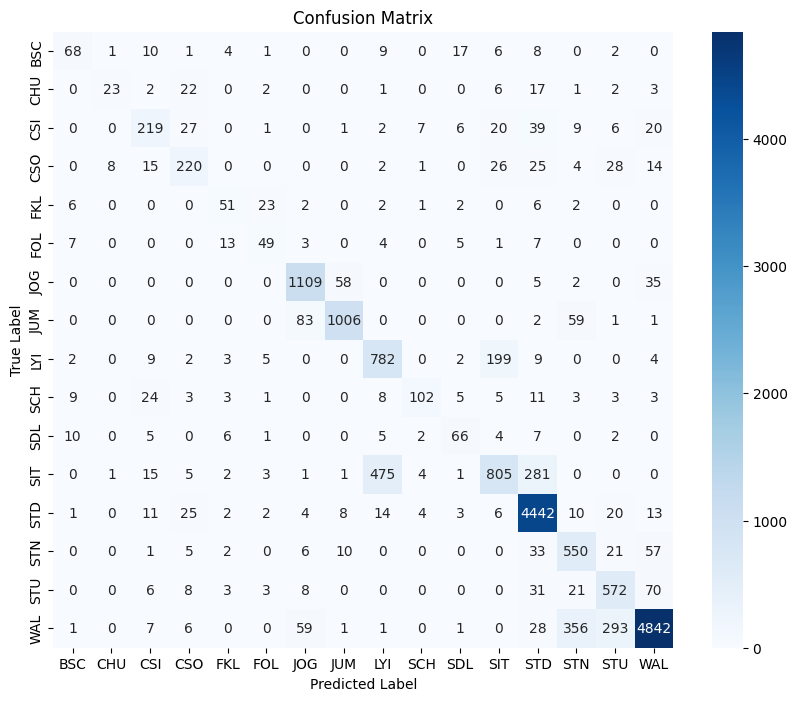

Classification Report:
               precision    recall  f1-score   support

         BSC       0.65      0.54      0.59       127
         CHU       0.70      0.29      0.41        79
         CSI       0.68      0.61      0.64       357
         CSO       0.68      0.64      0.66       343
         FKL       0.57      0.54      0.55        95
         FOL       0.54      0.55      0.54        89
         JOG       0.87      0.92      0.89      1209
         JUM       0.93      0.87      0.90      1152
         LYI       0.60      0.77      0.67      1017
         SCH       0.84      0.57      0.68       180
         SDL       0.61      0.61      0.61       108
         SIT       0.75      0.51      0.60      1594
         STD       0.90      0.97      0.93      4565
         STN       0.54      0.80      0.65       685
         STU       0.60      0.79      0.68       722
         WAL       0.96      0.87      0.91      5595

    accuracy                           0.83     17917
  

In [ ]:
label_classes = [
    'BSC', 'CHU', 'CSI', 'CSO', 'FKL', 'FOL', 
    'JOG', 'JUM', 'LYI', 'SCH', 'SDL', 'SIT', 
    'STD', 'STN', 'STU', 'WAL'
]
metrics = evaluate_model(model, X_test_windows, y_test_windows_encoded, label_classes=label_classes)
